Импорт нужных библиотек

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder,PowerTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score,precision_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
import opendatasets as od 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

In [2]:
od.download( 
    "https://www.kaggle.com/competitions/playground-series-s4e2") 


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading playground-series-s4e2.zip to .\playground-series-s4e2


100%|██████████| 917k/917k [00:01<00:00, 702kB/s]


Extracting archive .\playground-series-s4e2/playground-series-s4e2.zip to .\playground-series-s4e2


In [2]:
pd.set_option("display.max_columns", None)

In [3]:
df_train = pd.read_csv(r'C:\Users\snady\.spyder-py3\train_obesity.csv')
df_test = pd.read_csv(r'C:\Users\snady\.spyder-py3\test_obesity.csv')


In [235]:
# df = pd.read_csv('test.csv')

In [9]:
 df.drop(columns='id', inplace=True)



In [4]:
# Узнаем какие именно признаки нам подходят
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          20758 non-null  object 
 1   Age                             20758 non-null  float64
 2   Height                          20758 non-null  float64
 3   Weight                          20758 non-null  float64
 4   family_history_with_overweight  20758 non-null  object 
 5   FAVC                            20758 non-null  object 
 6   FCVC                            20758 non-null  float64
 7   NCP                             20758 non-null  float64
 8   CAEC                            20758 non-null  object 
 9   SMOKE                           20758 non-null  object 
 10  CH2O                            20758 non-null  float64
 11  SCC                             20758 non-null  object 
 12  FAF                             

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


c:\Users\snady\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\snady\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.15202620029689262
Recall: 0.269990366088632
F1: 0.16585857456969663


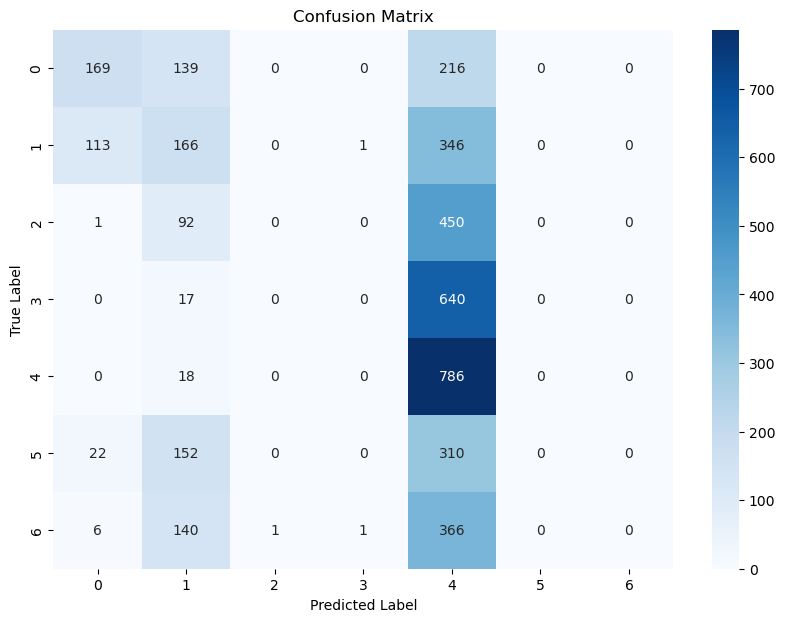

In [20]:
# Обучение модельки без обработки признаков 

lab_encoder = LabelEncoder()

df_train['NObeyesdad'] = lab_encoder.fit_transform(df_train['NObeyesdad'])
label_mapping = dict(zip(lab_encoder.classes_, lab_encoder.transform(lab_encoder.classes_)))
print(label_mapping)

df_num = df_train.select_dtypes(include=['int', 'float'])

X = df_num.drop(columns='NObeyesdad')
y = df_num['NObeyesdad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучаем модельку 
model = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=100, C=0.1)
model.fit(X_train, y_train)

# Смотрим метрики
y_pred = model.predict(X_test)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

# Вывод, даже при чередованиее кол-ва итерация, решателя и параметра регуляризации, модель не смога достичь сходимости для коэф. модели и найти оптимальное решение. 
# Построим матрицу ошибок
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lab_encoder.classes_, yticklabels=lab_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Precision: 0.8609471297089164
Recall: 0.86247591522158
F1: 0.861343029995342


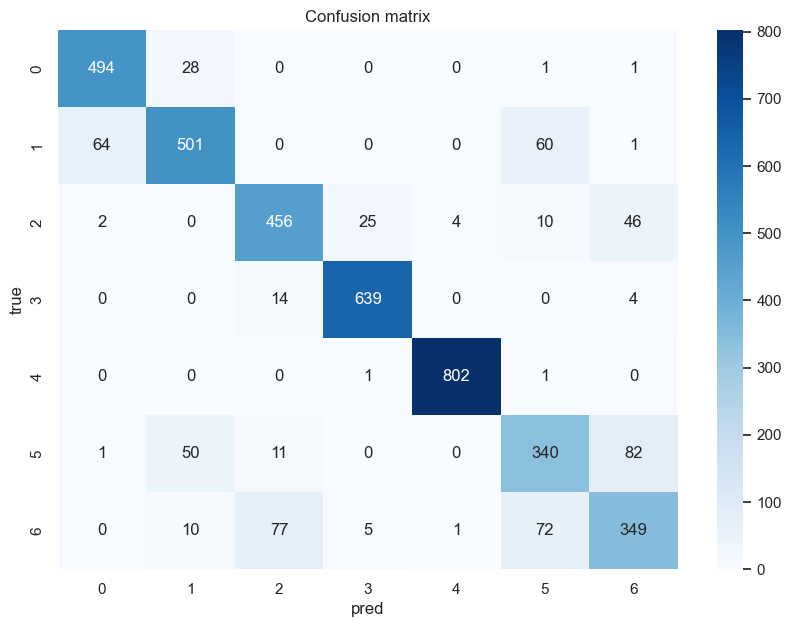

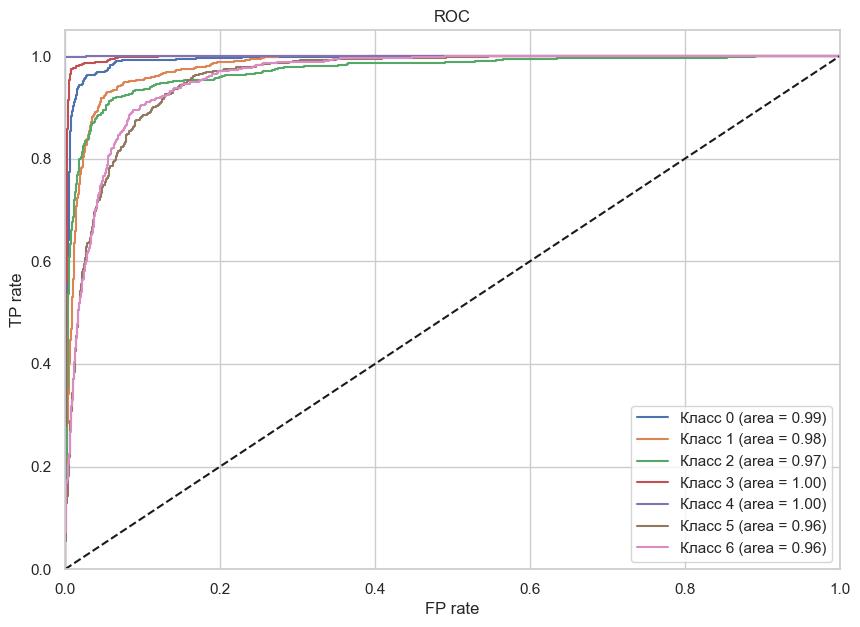

In [28]:
# Обучение модельки с обработкой признаков 
df_train.isnull().sum().sort_values(ascending=False)
df_train.duplicated().sum()
# df_train.drop(columns='id', inplace=True)

#Кодируем признаки 
lab_encoder = LabelEncoder()
for i in df_train.columns:
    if df_train[i].dtype == 'object':
        df_train[i] = lab_encoder.fit_transform(df_train[i])
        label_mapping = dict(zip(lab_encoder.classes_, lab_encoder.transform(lab_encoder.classes_)))
        print(label_mapping)

# Делим на выборки 
X = df_train.drop('NObeyesdad', axis=1)
y = df_train['NObeyesdad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Скейлим данные 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучаем модельку 
model = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=2000)
model.fit(X_train_scaled, y_train)

# Смотрим метрики
y_pred = model.predict(X_test_scaled)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

# Настройка стиля графиков
sns.set(style="whitegrid")

# conf matrrix 
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion matrix')
plt.xlabel('pred')
plt.ylabel('true')
plt.show()

# 2. ROC-cerve - каждый класс
y_prob = model.predict_proba(X_test_scaled)

# Создаем ROC-кривую для каждого класса
plt.figure(figsize=(10, 7))
for i in range(len(model.classes_)):
    fpr, tpr, _ = roc_curve(y_test, y_prob[:, i], pos_label=i)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='Класс {} (area = {:.2f})'.format(model.classes_[i], roc_auc))

plt.plot([0, 1], [0, 1], 'k--')  # Линия случайной классификации
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()



# При обработке признаков, немного поиграв с гиперпараметрами, удалось добиться следующих показателей, возможно при выборе другой модели получиться добюиться лучшего результата 



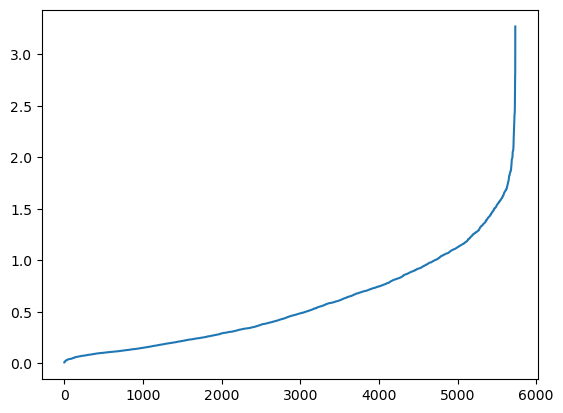

Precision: 0.8182577069409604
Recall: 0.5903686087990487
F1: 0.5725980569401168
Best parameters: {'C': 10, 'max_iter': 20000, 'solver': 'saga', 'tol': 1e-05}


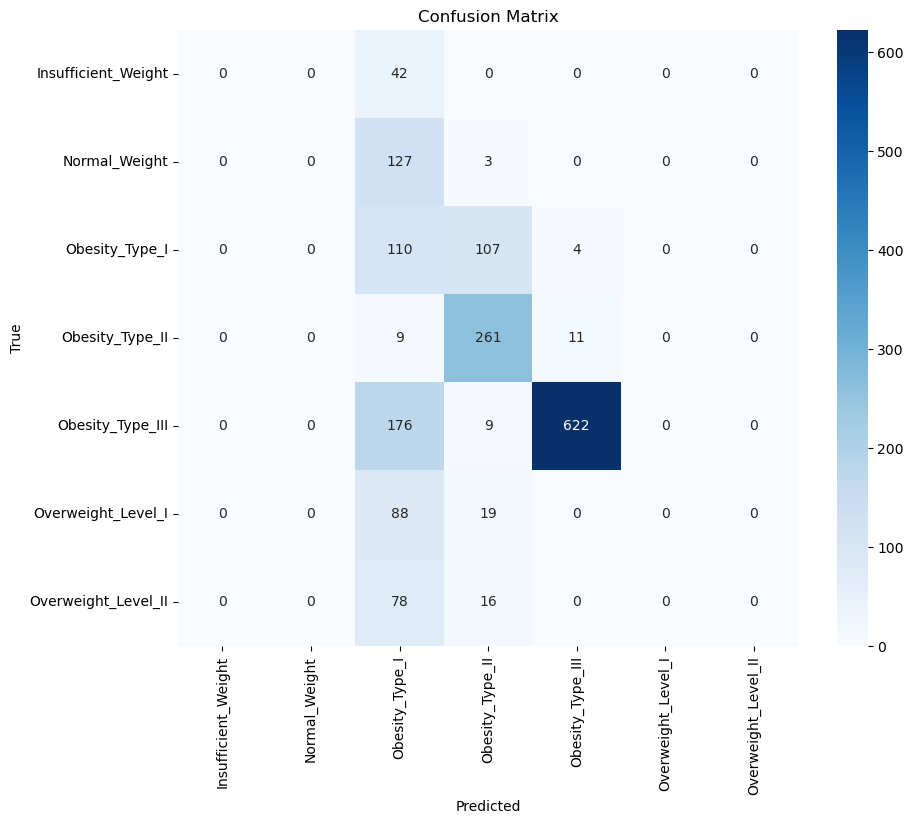

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import warnings
from sklearn.exceptions import ConvergenceWarning
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Загрузка данных
df = pd.read_csv(r'C:\Users\snady\.spyder-py3\train_obesity.csv')

# Кодирование категориальных признаков
lab_encoder = LabelEncoder()
for i in df.columns:
    if df[i].dtype == 'object':
        df[i] = lab_encoder.fit_transform(df[i])

# Разделение на выборки
X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# IQR для обучающей выборки
def detect_outliers_iqr(data, features):
    outliers_index = []
    for feature in features:
        Q1 = np.percentile(data[feature], 25)
        Q3 = np.percentile(data[feature], 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_index.extend(data[(data[feature] < lower_bound) | (data[feature] > upper_bound)].index.tolist())
    return list(set(outliers_index))

outliers_iqr_train_index = detect_outliers_iqr(X_train, X_train.columns)
X_train_cleaned = X_train.drop(outliers_iqr_train_index)
y_train_cleaned = y_train.drop(outliers_iqr_train_index)
y_train_cleaned = y_train_cleaned.reset_index(drop=True)

# Удаление выбросов из тестовой выборки
outliers_iqr_test_index = detect_outliers_iqr(X_test, X_train.columns)
X_test_cleaned = X_test.drop(outliers_iqr_test_index)
y_test_cleaned = y_test.drop(outliers_iqr_test_index)
y_test_cleaned = y_test_cleaned.reset_index(drop=True)

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_cleaned)
X_test_scaled = scaler.transform(X_test_cleaned)

# Определение оптимального eps для DBSCAN
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(X_train_scaled)
distances, indices = neighbors_fit.kneighbors(X_train_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.plot(distances)  
plt.show()  
optimal_eps = 0.4  

# DBSCAN для обучающей выборки
dbscan = DBSCAN(eps=optimal_eps, min_samples=4)
labels_train = dbscan.fit_predict(X_train_scaled)

non_outlier_indices = np.where(labels_train != -1)[0]
X_train_final = X_train_scaled[non_outlier_indices]
y_train_final = y_train_cleaned.iloc[non_outlier_indices]

# Подбор гиперпараметров модели
param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['saga'],
    'max_iter': [10000, 20000],
    'tol': [1e-4, 1e-5]
}

model = LogisticRegression(multi_class='multinomial', class_weight='balanced')
grid_search = GridSearchCV(model, param_grid, cv=4, scoring='f1_weighted', n_jobs=-1)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    grid_search.fit(X_train_final, y_train_final)

best_model = grid_search.best_estimator_

# Оценка модели
y_pred = best_model.predict(X_test_scaled)

precision = precision_score(y_test_cleaned, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test_cleaned, y_pred, average='weighted')
f1 = f1_score(y_test_cleaned, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")
print(f"Best parameters: {grid_search.best_params_}")

# conf. матрица 
cm = confusion_matrix(y_test_cleaned, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lab_encoder.classes_, yticklabels=lab_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
df_train = pd.read_csv(r'C:\Users\snady\.spyder-py3\train_obesity.csv')


In [ ]:
df_train.head()

#df_train.isnull().sum().sort_values(ascending=False)


id                                0
Gender                            0
MTRANS                            0
CALC                              0
TUE                               0
FAF                               0
SCC                               0
CH2O                              0
SMOKE                             0
CAEC                              0
NCP                               0
FCVC                              0
FAVC                              0
family_history_with_overweight    0
Weight                            0
Height                            0
Age                               0
NObeyesdad                        0
dtype: int64

In [238]:
# Расшифровки:
# FAVC - Frequent consumption of high caloric food (Частое употребление высококалорийной пищи). Тип данных: object (вероятно, категориальный признак). Возможные значения: «yes»/«no» или аналогичные категории
# FCVC - Frequency of consumption of vegetables (Частота употребления овощей). Тип данных: int64 (вероятно, количественный признак). Возможные значения: количество раз в день/неделю или аналогичные метрики
# NCP - Number of main meals (Количество основных приемов пищи). Тип данных: int64 (вероятно, количественный признак). Возможные значения: целое число, обозначающее количество основных приемов пищи в день
# CAEC - Consumption of food between meals (Употребление пищи между приемами пищи). Тип данных: object (вероятно, категориальный признак). Возможные значения: «yes»/«no» или аналогичные категории
# CH2O - Consumption of water daily (Употребление воды в день). Тип данных: float64 (вероятно, количественный признак). Возможные значения: количество литров/стаканов воды, употребляемой в день
# SCC - Calories consumption monitoring (Мониторинг потребления калорий). Тип данных: object (вероятно, категориальный признак). Возможные значения: «yes»/«no» или аналогичные категории
# FAF - Physical activity frequency (Частота физической активности). Тип данных: int64 (вероятно, количественный признак). Возможные значения: количество раз в день/неделю или аналогичные метрики
# TUE - Time using technology devices (Время, проводимое за использованием технологических устройств). Тип данных: float64 (вероятно, количественный признак). Возможные значения: количество часов/минут в день, проводимых за использованием устройств
# CALC - Consumption of alcohol (Употребление алкоголя). Тип данных: object (вероятно, категориальный признак). Возможные значения: «yes»/«no» или аналогичные категории

In [29]:
df_train = df_train.rename({'family_history_with_overweight':'FamilyOverweightHistory'},axis='columns')
df_test = df_test.rename({'family_history_with_overweight':'FamilyOverweightHistory'},axis='columns')


In [240]:
#df.describe(include='all')

In [30]:
df_test.isnull().sum().sort_values(ascending=False)

id                         0
CAEC                       0
CALC                       0
TUE                        0
FAF                        0
SCC                        0
CH2O                       0
SMOKE                      0
NCP                        0
Gender                     0
FCVC                       0
FAVC                       0
FamilyOverweightHistory    0
Weight                     0
Height                     0
Age                        0
MTRANS                     0
dtype: int64

In [31]:
df_test.duplicated().sum()

0

In [32]:
df_train.duplicated().sum()

0

In [33]:
df_train.head()

,Gender,Age,Height,Weight,FamilyOverweightHistory,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,1,24.443011,1.699998,81.669950,1,1,2.000000,2.983297,2,0,2.763573,0,0.000000,0.976473,1,3,6
1,0,18.000000,1.560000,57.000000,1,1,2.000000,3.000000,1,0,2.000000,0,1.000000,1.000000,2,0,1
2,0,18.000000,1.711460,50.165754,1,1,1.880534,1.411685,2,0,1.910378,0,0.866045,1.673584,2,3,0
3,0,20.952737,1.710730,131.274851,1,1,3.000000,3.000000,2,0,1.674061,0,1.467863,0.780199,1,3,4
4,1,31.641081,1.914186,93.798055,1,1,2.679664,1.971472,2,0,1.979848,0,1.967973,0.931721,1,3,6


In [83]:
lab_encoder = LabelEncoder()
for i in df_train.columns:
    if df_train[i].dtype == 'object':
        df_train[i] = lab_encoder.fit_transform(df_train[i])
        label_mapping = dict(zip(lab_encoder.classes_, lab_encoder.transform(lab_encoder.classes_)))
        print(label_mapping)

In [84]:
lab_encoder = LabelEncoder()
for i in df_test.columns:
    if df_test[i].dtype == 'object':
        df_test[i] = lab_encoder.fit_transform(df_test[i])
        label_mapping = dict(zip(lab_encoder.classes_, lab_encoder.transform(lab_encoder.classes_)))
        print(label_mapping)

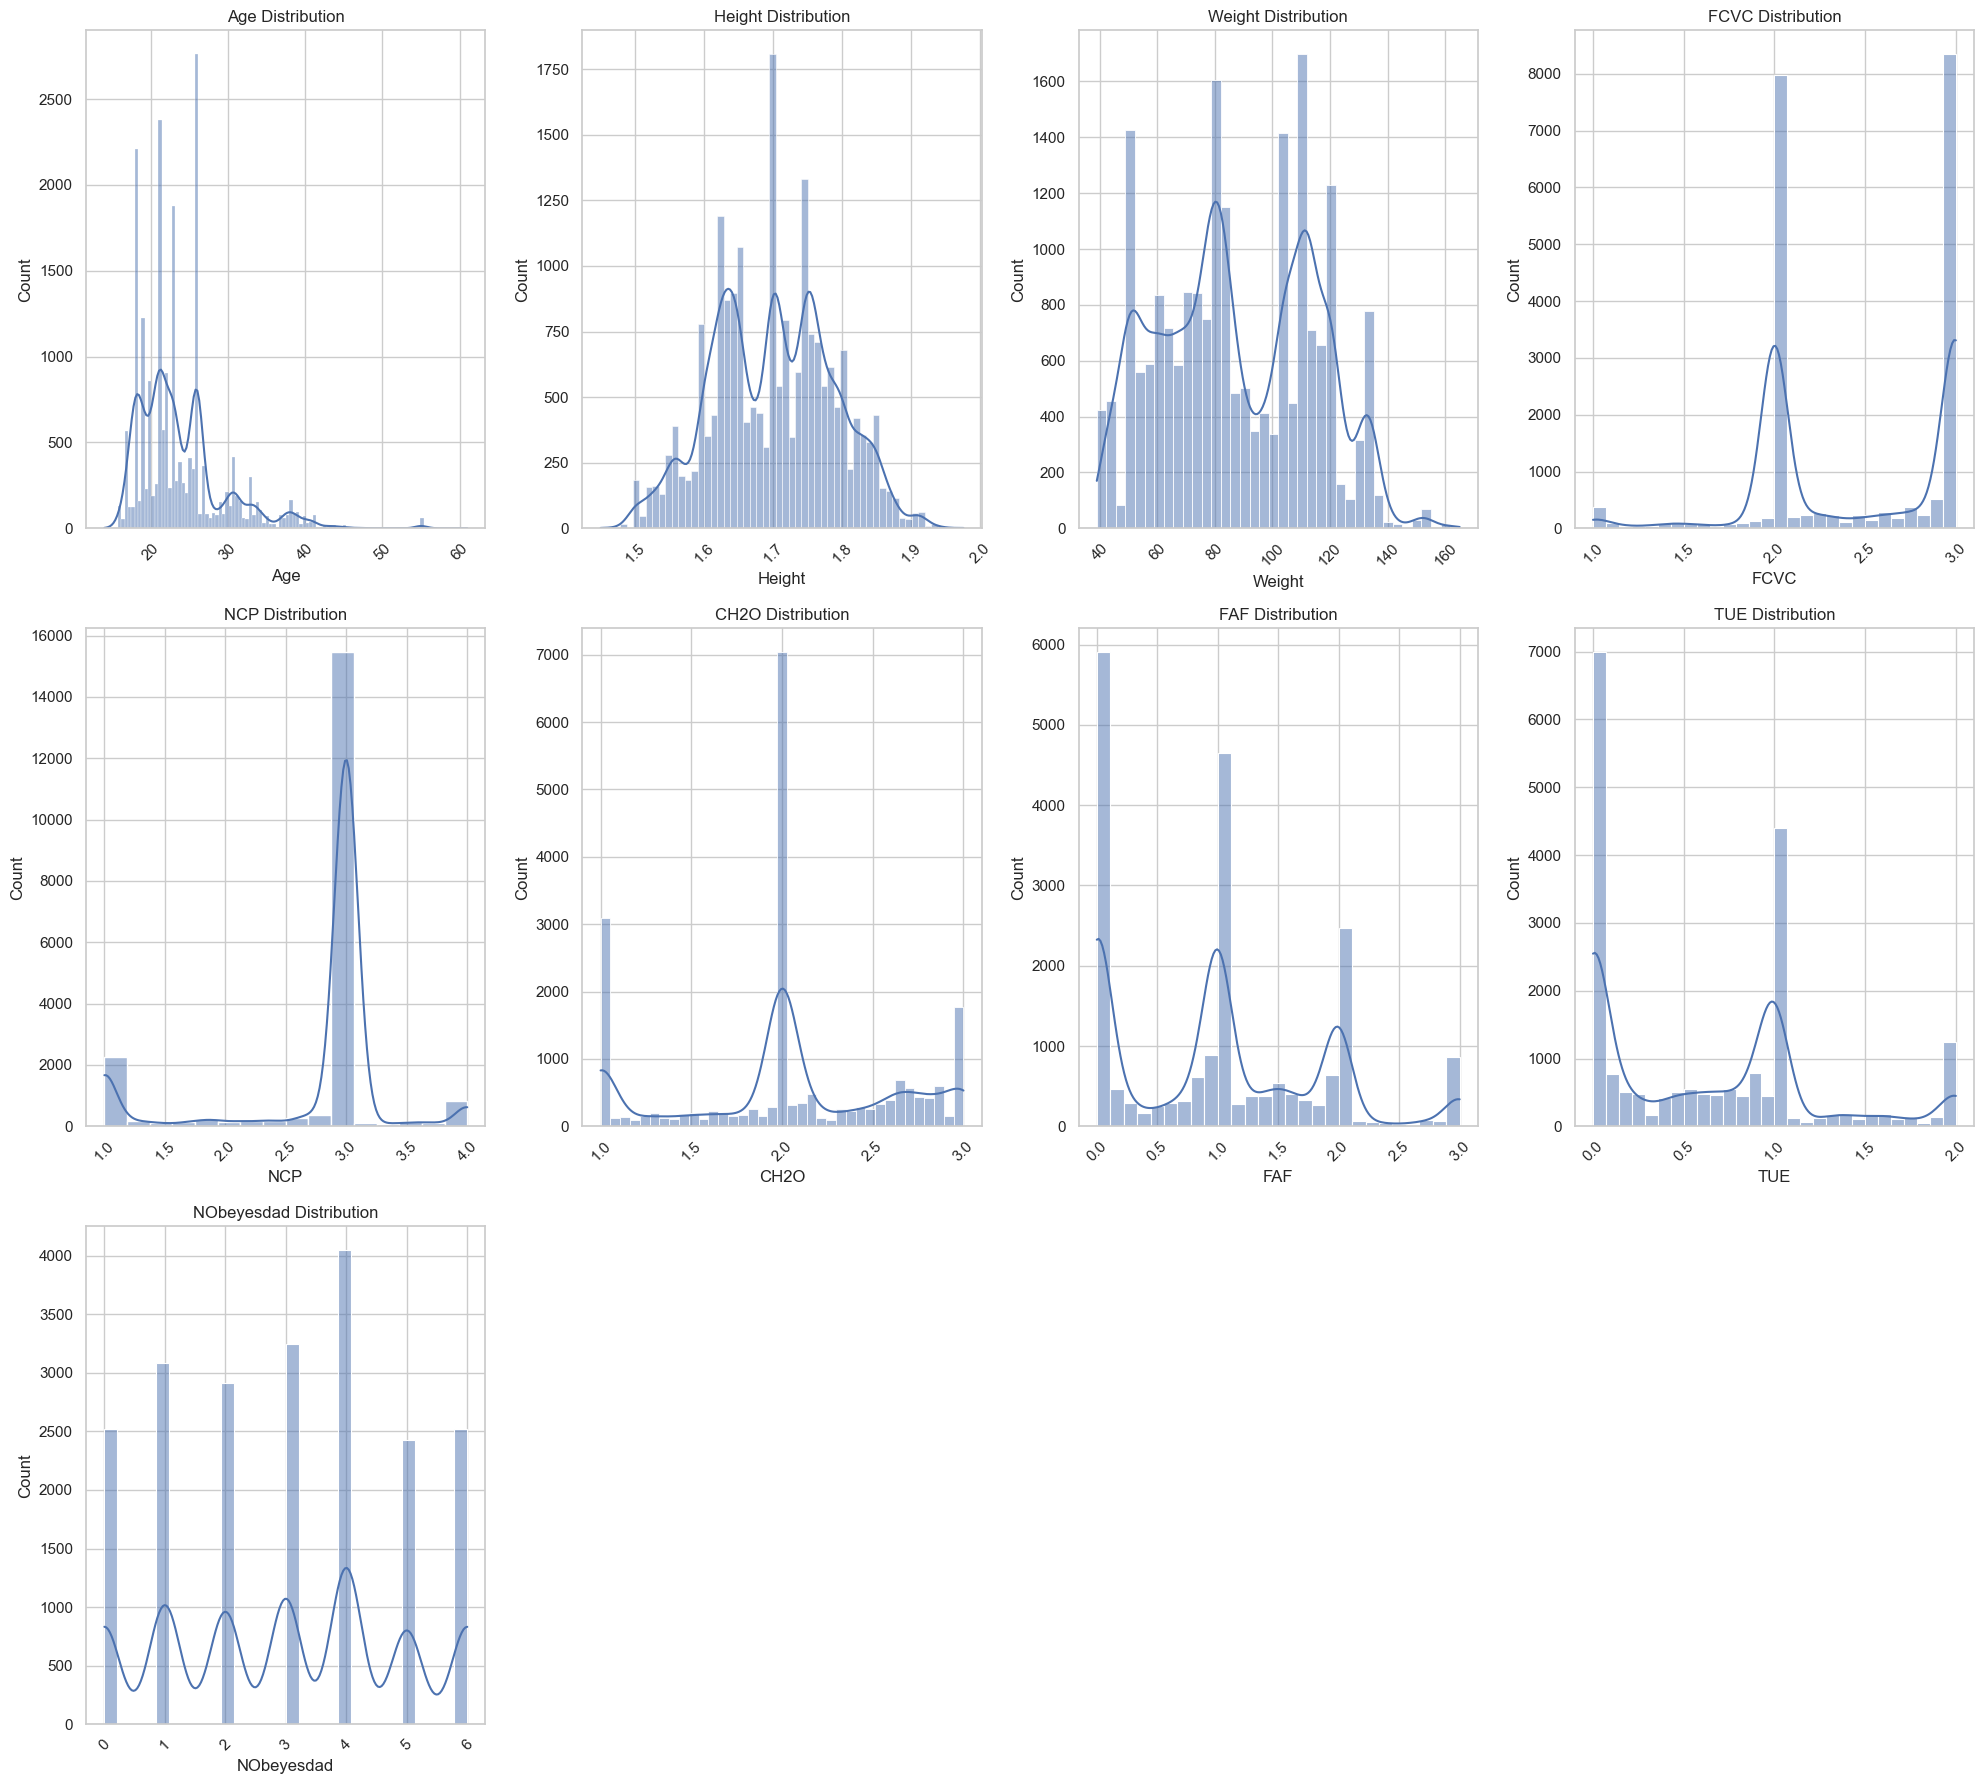

In [37]:
sns.set(style="whitegrid")
numerical_columns = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = df_train.select_dtypes(include=['object']).columns.tolist()
num_cols = len(numerical_columns)
num_rows = -(-num_cols // 4) 

plt.figure(figsize=(20, 6 * num_rows))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(num_rows, 4, i)
    sns.histplot(df_train[col], kde=True)
    plt.title(f'{col} Distribution')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [38]:
df_train['Age']=df_train['Age'].astype(int)
df_train['Height']=df_train['Height'].astype(float).round(2)
df_train['Weight']=df_train['Weight'].astype(float).round(2)
df_train['FCVC']=df_train['FCVC'].astype(int)
df_train['NCP']=df_train['NCP'].astype(int)
df_train['CH2O']=df_train['CH2O'].astype(float).round(2)
df_train['FAF']=df_train['FAF'].astype(int)
df_train['TUE']=df_train['TUE'].astype(float).round(2)

In [39]:
df_test['Age']=df_train['Age'].astype(int)
df_test['Height']=df_test['Height'].astype(float).round(2)
df_test['Weight']=df_test['Weight'].astype(float).round(2)
df_test['FCVC']=df_test['FCVC'].astype(int)
df_test['NCP']=df_test['NCP'].astype(int)
df_test['CH2O']=df_test['CH2O'].astype(float).round(2)
df_test['FAF']=df_test['FAF'].astype(int)
df_test['TUE']=df_test['TUE'].astype(float).round(2)

1. Посмотрели данные, проверили пропуски
2. Скорректировали имя колонки
3. Закодировали категориальные данные

In [40]:
df_train['BMI'] = (df_train['Weight'] / pow(df_train['Height'], 2)).round(2)

def categorize(value):
    if value <= 16:
        return 'Very low'
    elif 16 < value <= 18.5:
        return 'Low'
    elif 18.5 < value <= 25:
        return 'Normal'
    elif 25 < value <= 30:
        return 'Above normal'
    elif 30 < value <= 35:
        return '1st class'
    elif 35 < value <= 40:
        return '2nd class'
    else:
        return '3rd class'

df_train['BMICategory'] = df_train['BMI'].map(categorize)
    


In [41]:
df_test['BMI'] = (df_test['Weight'] / pow(df_test['Height'], 2)).round(2)

def categorize(value):
    if value <= 16:
        return 'Very low'
    elif 16 < value <= 18.5:
        return 'Low'
    elif 18.5 < value <= 25:
        return 'Normal'
    elif 25 < value <= 30:
        return 'Above normal'
    elif 30 < value <= 35:
        return '1st class'
    elif 35 < value <= 40:
        return '2nd class'
    else:
        return '3rd class'

df_test['BMICategory'] = df_test['BMI'].map(categorize)

In [42]:
# Кодируем значения
lab_encoder = LabelEncoder()
df_train["BMICategory"] = lab_encoder.fit_transform(df_train["BMICategory"])

# Выведем соответствие исходных значений и их кодированных меток
print("Соответствие исходных значений и кодов BMICategory:")
label_mapping = dict(zip(lab_encoder.classes_, lab_encoder.transform(lab_encoder.classes_)))
print(label_mapping)

Соответствие исходных значений и кодов BMICategory:
{'1st class': 0, '2nd class': 1, '3rd class': 2, 'Above normal': 3, 'Low': 4, 'Normal': 5, 'Very low': 6}


In [43]:
# Кодируем значения
lab_encoder = LabelEncoder()
df_test["BMICategory"] = lab_encoder.fit_transform(df_test["BMICategory"])

# Выведем соответствие исходных значений и их кодированных меток
print("Соответствие исходных значений и кодов BMICategory:")
label_mapping = dict(zip(lab_encoder.classes_, lab_encoder.transform(lab_encoder.classes_)))
print(label_mapping)

Соответствие исходных значений и кодов BMICategory:
{'1st class': 0, '2nd class': 1, '3rd class': 2, 'Above normal': 3, 'Low': 4, 'Normal': 5, 'Very low': 6}


In [ ]:
#df.to_csv("submission.csv", index=False)

In [44]:
# Создаем бины, которые содержат показатели категорий, границы групп. 
bins = [0, 12, 18, 35, 60, float('inf')] 
# Названия возрастных групп
labels = ['Kids', 'Teens', 'Young adults', 'Middle age', 'Elderly'] 
# Функция cut делит данные на интервалы 
df_train['Age_Category'] = pd.cut(df_train['Age'], bins=bins, labels=labels, right=False)

df_train.head() 

,Gender,Age,Height,Weight,FamilyOverweightHistory,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI,BMICategory,Age_Category
0,1,24,1.70,81.67,1,1,2,2,2,0,2.76,0,0,0.98,1,3,6,28.26,3,Young adults
1,0,18,1.56,57.00,1,1,2,3,1,0,2.00,0,1,1.00,2,0,1,23.42,5,Young adults
2,0,18,1.71,50.17,1,1,1,1,2,0,1.91,0,0,1.67,2,3,0,17.16,4,Young adults
3,0,20,1.71,131.27,1,1,3,3,2,0,1.67,0,1,0.78,1,3,4,44.89,2,Young adults
4,1,31,1.91,93.80,1,1,2,1,2,0,1.98,0,1,0.93,1,3,6,25.71,3,Young adults


In [45]:
# Создаем бины, которые содержат показатели категорий, границы групп. 
bins = [0, 12, 18, 35, 60, float('inf')] 
# Названия возрастных групп
labels = ['Kids', 'Teens', 'Young adults', 'Middle age', 'Elderly'] 
# Функция cut делит данные на интервалы 
df_test['Age_Category'] = pd.cut(df_test['Age'], bins=bins, labels=labels, right=False)

df_test.head() 

,id,Gender,Age,Height,Weight,FamilyOverweightHistory,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,BMI,BMICategory,Age_Category
0,20758,1,24,1.85,120.64,1,1,2,3,2,0,2.83,0,0,0.00,2,3,35.25,1,Young adults
1,20759,0,18,1.60,66.00,1,1,2,1,2,0,3.00,0,1,0.00,2,3,25.78,3,Young adults
2,20760,0,18,1.64,111.60,1,1,3,3,2,0,2.62,0,0,0.25,2,3,41.49,2,Young adults
3,20761,1,20,1.55,103.67,1,1,2,2,2,0,2.79,0,0,0.00,2,3,43.15,2,Young adults
4,20762,0,31,1.63,104.84,1,1,3,3,2,0,2.65,0,0,0.74,2,3,39.46,1,Young adults


In [46]:
# Кодируем значения
lab_encoder = LabelEncoder()
df_train["Age_Category"] = lab_encoder.fit_transform(df_train["Age_Category"])

# Выведем соответствие исходных значений и их кодированных меток
print("Соответствие исходных значений и кодов BMICategory:")
label_mapping = dict(zip(lab_encoder.classes_, lab_encoder.transform(lab_encoder.classes_)))
print(label_mapping)

Соответствие исходных значений и кодов BMICategory:
{'Elderly': 0, 'Middle age': 1, 'Teens': 2, 'Young adults': 3}


In [47]:
# Кодируем значения
lab_encoder = LabelEncoder()
df_test["Age_Category"] = lab_encoder.fit_transform(df_test["Age_Category"])

# Выведем соответствие исходных значений и их кодированных меток
print("Соответствие исходных значений и кодов BMICategory:")
label_mapping = dict(zip(lab_encoder.classes_, lab_encoder.transform(lab_encoder.classes_)))
print(label_mapping)

Соответствие исходных значений и кодов BMICategory:
{'Elderly': 0, 'Middle age': 1, 'Teens': 2, 'Young adults': 3}


In [48]:
df_test = df_test.drop('id', axis=1)
df_train = df_train.drop('id', axis=1)

KeyError: "['id'] not found in axis"

In [ ]:
# Делим данные на выборки
X = df_train.drop('NObeyesdad', axis=1)
y = df_train['NObeyesdad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [50]:
# Делаем значения более приятными для визуального восприятия после стандартизации 
np.set_printoptions(suppress=True)

In [51]:
# Номрализуем данные # Гипотеза 1 - для нашей задачи min-max scaler будет работать лучше 
scaler = MinMaxScaler()
X_train_normalized = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
# К test применяем только трансформ, чтобы избежать утечки данных
X_test_normalized = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [52]:
# Исследуем дисперсию, чтобы задать treshhold
variances = np.var(X_train_normalized, axis=0)
print("Дисперсии признаков:\n", variances)




Дисперсии признаков:
 Gender                     0.249997
Age                        0.014663
Height                     0.027171
Weight                     0.043609
FamilyOverweightHistory    0.146011
FAVC                       0.077750
FCVC                       0.086633
NCP                        0.063597
CAEC                       0.022620
SMOKE                      0.011664
CH2O                       0.092197
SCC                        0.032754
FAF                        0.076509
TUE                        0.091243
CALC                       0.055895
MTRANS                     0.083116
BMI                        0.039053
BMICategory                0.079455
Age_Category               0.027556
dtype: float64


In [46]:
X_train_normalized.shape

(16606, 20)

In [53]:
# Метод 1 
selector = VarianceThreshold(threshold=0.02)

X_selected_train = selector.fit_transform(X_train_normalized)
X_selected_test = selector.transform(X_test_normalized)

# Используем get_support чотбы сохранить названия колонок 
selected_features = X_train_normalized.columns[selector.get_support()]

X_selected_train_df = pd.DataFrame(X_selected_train, columns=selected_features)
X_selected_test_df = pd.DataFrame(X_selected_test, columns=selected_features)

X_selected_train_df.head()


,Gender,Height,Weight,FamilyOverweightHistory,FAVC,FCVC,NCP,CAEC,CH2O,SCC,FAF,TUE,CALC,MTRANS,BMI,BMICategory,Age_Category
0,1.0,0.603774,0.460098,1.0,1.0,1.0,0.666667,0.000000,0.500,0.0,1.000000,0.5,1.0,0.00,0.425961,0.000000,0.666667
1,1.0,0.566038,0.125972,1.0,1.0,0.5,1.000000,0.666667,0.500,0.0,0.666667,0.5,1.0,0.75,0.116516,0.666667,1.000000
2,1.0,0.698113,0.658575,1.0,1.0,1.0,0.333333,0.666667,0.325,0.0,0.000000,0.0,0.5,0.75,0.565496,0.166667,1.000000
3,0.0,0.245283,0.325242,1.0,1.0,0.5,0.666667,0.666667,0.000,0.0,0.000000,0.0,0.5,0.00,0.451827,0.000000,0.333333
4,1.0,0.660377,0.444233,1.0,0.0,1.0,0.666667,0.666667,1.000,0.0,0.666667,0.5,0.0,0.75,0.387043,0.500000,1.000000


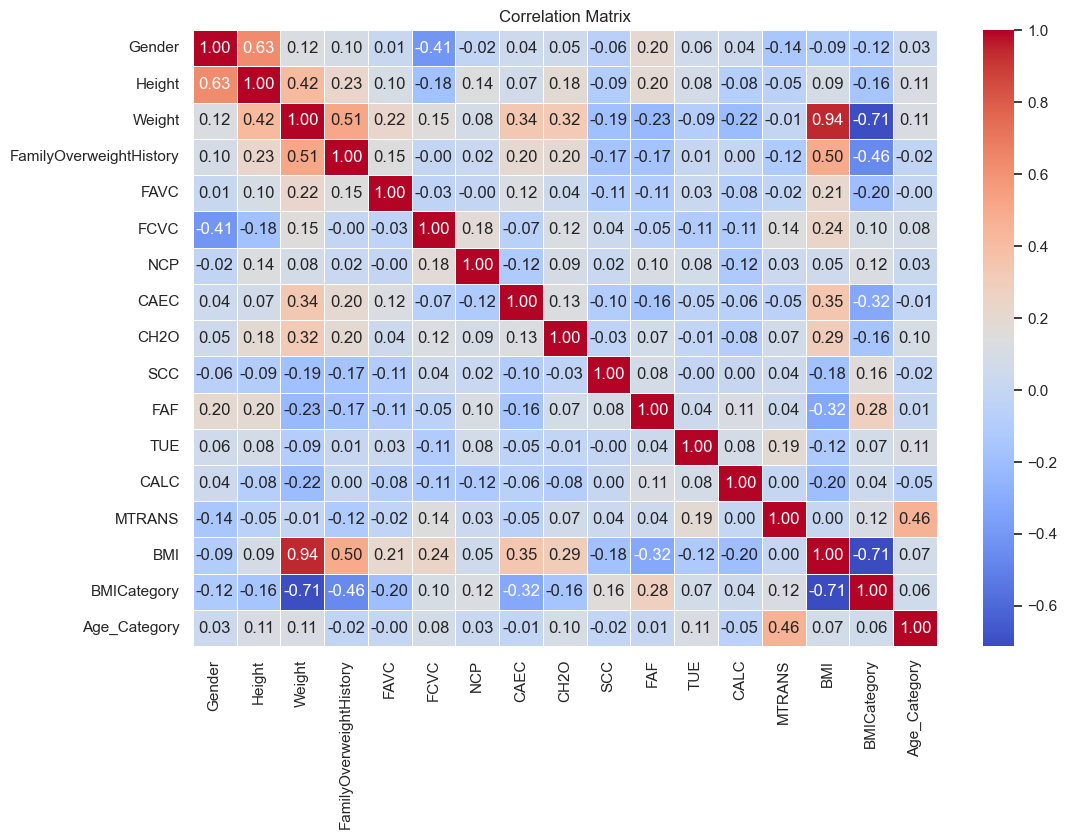

In [65]:
plt.figure(figsize=(12, 8))
sns.heatmap(X_selected_train_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [96]:
df_recovery = pd.DataFrame(pd.read_csv(r'C:\Users\snady\.spyder-py3\train_obesity.csv'))
rec_label = LabelEncoder()
df_recovery['NObeyesdad'] = rec_label.fit_transform(df_recovery['NObeyesdad'])
label_mapping = dict(zip(rec_label.classes_, rec_label.transform(rec_label.classes_)))
print(label_mapping)



{'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Obesity_Type_I': 2, 'Obesity_Type_II': 3, 'Obesity_Type_III': 4, 'Overweight_Level_I': 5, 'Overweight_Level_II': 6}


In [102]:
class_names = rec_label.classes_
print(class_names)

['Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_I' 'Obesity_Type_II'
 'Obesity_Type_III' 'Overweight_Level_I' 'Overweight_Level_II']


Accuracy: 0.85
F1 Score: 0.85
Recall: 0.85
Precision: 0.85


Text(92.10937499999999, 0.5, 'True')

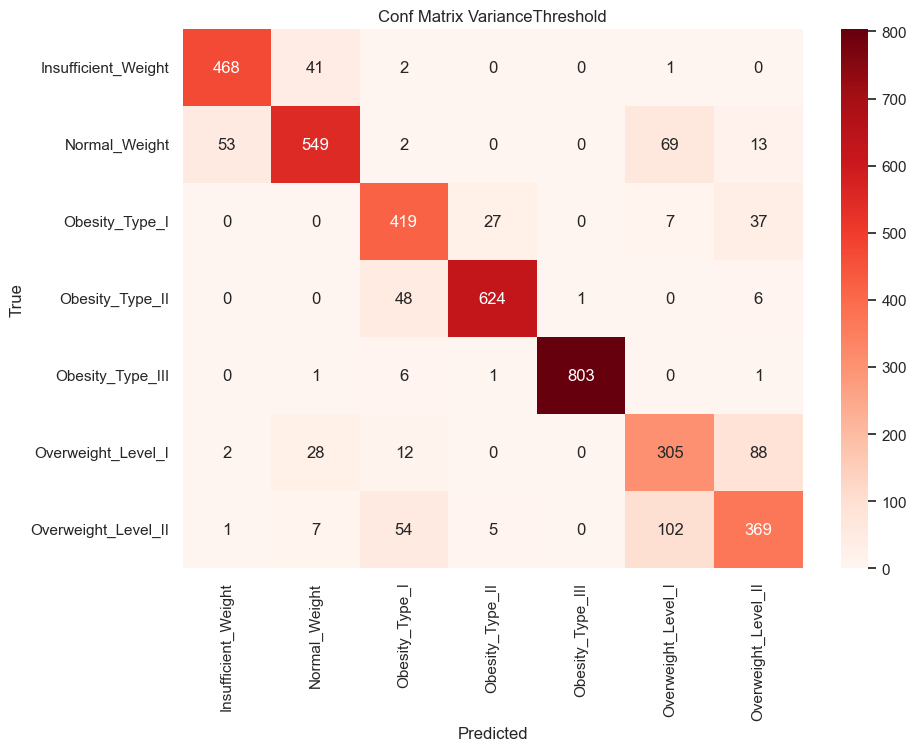

In [98]:
# Удалено 2 признака, проверям насколько применим данный метод к нашей модели. 
model = LogisticRegression(max_iter=500)  # Увеличиваем max_iter для лучшей сходимости
model.fit(X_selected_train_df, y_train)
y_pred = model.predict(X_selected_test_df)

# Оцениваем модель 
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # average='weighted' для многоклассовой классификации
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')

conf_matrix = confusion_matrix(y_pred, y_test)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix,fmt='d', annot=True, cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.title('Conf Matrix VarianceThreshold')
plt.xlabel('Predicted')
plt.ylabel('True')



In [99]:
# Метод 2  ANOVA - попроьуем выбрать 15 лучших признаков 
selector = SelectKBest(f_classif, k=15)

X_anova_train = selector.fit_transform(X_train_normalized, y_train)
X_anova_test = selector.transform(X_test_normalized)  
# Используем get_support чотбы сохранить названия колонок 
selected_features = X_train_normalized.columns[selector.get_support()]

X_anova_train_df = pd.DataFrame(X_anova_train, columns=selected_features)
X_anova_test_df = pd.DataFrame(X_anova_test, columns=selected_features)

X_anova_train_df.head()

,Gender,Age,Height,Weight,FamilyOverweightHistory,FAVC,FCVC,NCP,CAEC,CH2O,FAF,CALC,MTRANS,BMI,BMICategory
0,1.0,0.063830,0.603774,0.460098,1.0,1.0,1.0,0.666667,0.000000,0.500,1.000000,1.0,0.00,0.425961,0.000000
1,1.0,0.170213,0.566038,0.125972,1.0,1.0,0.5,1.000000,0.666667,0.500,0.666667,1.0,0.75,0.116516,0.666667
2,1.0,0.148936,0.698113,0.658575,1.0,1.0,1.0,0.333333,0.666667,0.325,0.000000,0.5,0.75,0.565496,0.166667
3,0.0,0.574468,0.245283,0.325242,1.0,1.0,0.5,0.666667,0.666667,0.000,0.000000,0.5,0.00,0.451827,0.000000
4,1.0,0.191489,0.660377,0.444233,1.0,0.0,1.0,0.666667,0.666667,1.000,0.666667,0.0,0.75,0.387043,0.500000


Accuracy: 0.86
F1 Score: 0.86
Recall: 0.86
Precision: 0.86


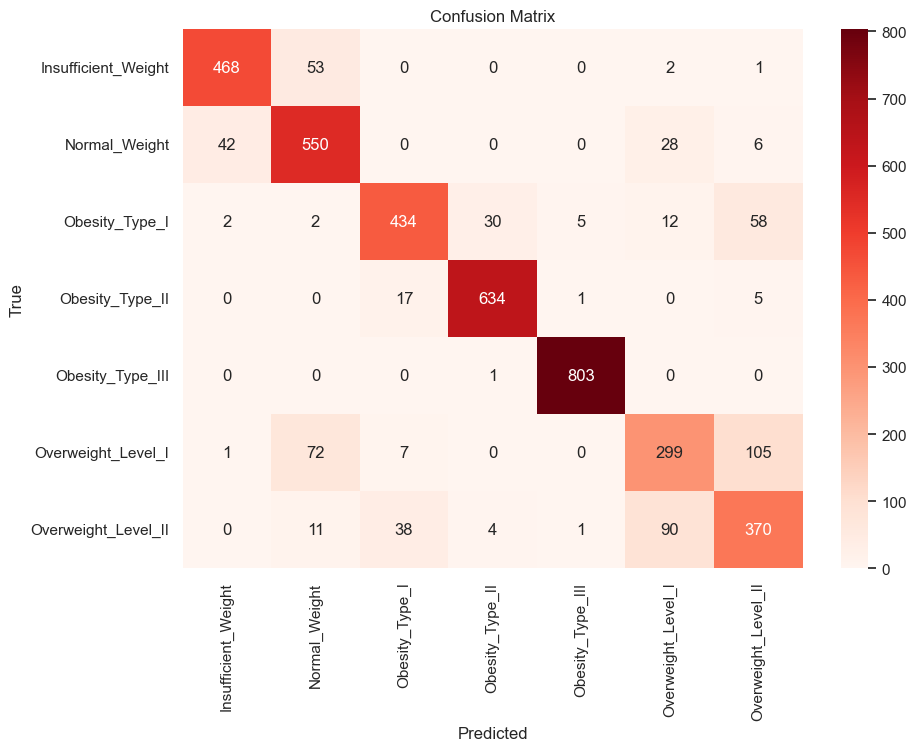

In [103]:
# Удалено 5 признаков, проверям насколько применим данный метод к нашей модели. 
model = LogisticRegression(max_iter=500)  # Увеличиваем max_iter для лучшей сходимости
model.fit(X_anova_train_df, y_train)
y_pred = model.predict(X_anova_test_df)

# Оцениваем модель 
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # average='weighted' для многоклассовой классификации
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')

# Conf Matrix 
conf_matrix = confusion_matrix(y_test, y_pred)

# Построение графика матрицы путаницы
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, cmap='Reds', fmt='d',  xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



Accuracy: 0.82
F1 Score: 0.82
Recall: 0.82
Precision: 0.83


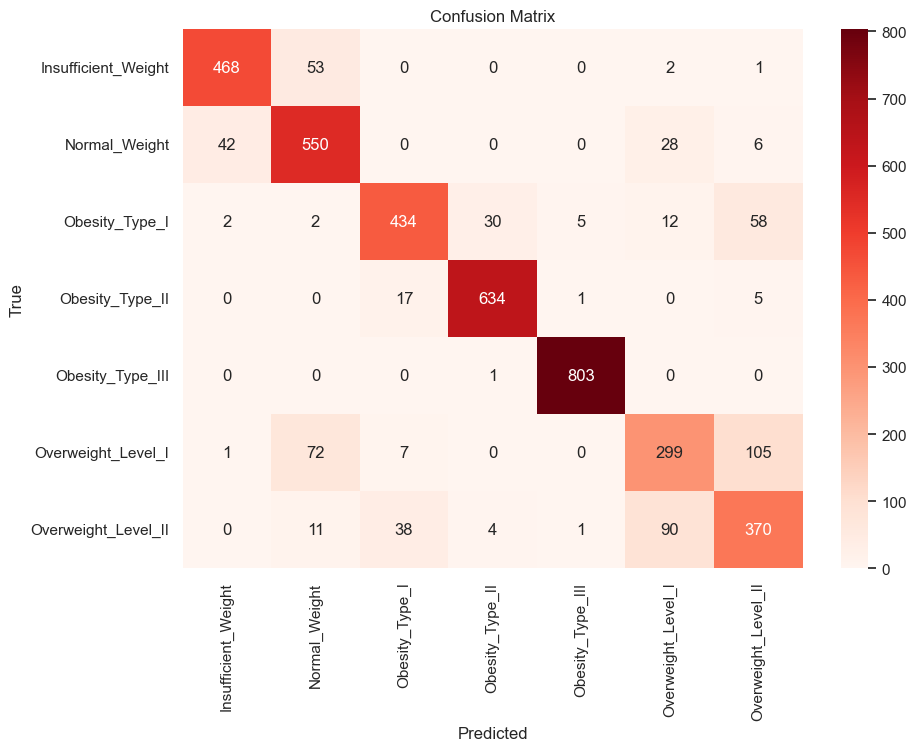

In [105]:
# Метод 3 - отбор признаков при помощи Логистической регрессии
pipe = make_pipeline(SelectFromModel(estimator=LogisticRegression(max_iter=500)), LogisticRegression(max_iter=500))

pipe.fit(X_train_normalized, y_train)
y_pred = pipe.predict(X_test_normalized)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # average='weighted' для многоклассовой классификации
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')

# Построение графика матрицы путаницы
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, cmap='Reds', fmt='d',  xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()